In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from pygam import LinearGAM
from pygam.utils import generate_X_grid

In [17]:
df_all = pd.read_csv('fanfic_regression_data_curated.tsv', sep = '\t')

### GAM

In [18]:
df_all = df_all.sort_values(by = 'Kudos')[:-5]
df_all = df_all.sort_values(by = 'Hits')[:-5]
df_all = df_all.sort_values(by = 'Comments')[:-5]
df_all = df_all.sort_values(by = 'Bookmarks')[:-5]

In [19]:
# df_all = df_all.sample(1000)

In [20]:
df_all = df_all.replace([np.inf, -np.inf], np.nan)
df_all = df_all.dropna(how = 'any')

In [21]:
len(df_all)

701647

In [22]:
X = df_all[['ChapterIndex', 'Chapters','Term_novelty', 'Topic_novelty',
        'Category_F_M', 'Category_Gen', 'Category_M_M',
       'Category_Multi', 'Category_Other', 'Category_Unknown',
        'ArchiveWarnings_underage',
       'ArchiveWarnings_death', 'ArchiveWarnings_choose_no',
       'ArchiveWarnings_no_apply',
       'ArchiveWarnings_violence', 'ArchiveWarnings_noncon',
       'author_fic_cnt',  'Rating_G', 'Rating_M', 'Rating_N',
       'Rating_T', 'Freq_relationship',
       'Fandom_dcu', 'Fandom_doctor_who', 'Fandom_star_wars',
       'Fandom_arthurian', 'Fandom_supernatural', 'Fandom_haikyuu',
       'Fandom_kuroko_no_basuke', 'Fandom_hamilton_miranda',
       'Fandom_dragon_age', 'Fandom_the_walking_dead', 'Fandom_buffy',
       'Fandom_les_miserables', 'Fandom_naruto', 'Fandom_tolkien',
       'Fandom_shakespare', 'Fandom_hetalia', 'Fandom_attack_on_titan',
       'Fandom_ms_paint_adventures', 'Fandom_homestuck', 'Fandom_marvel',
       'Fandom_sailor_moon', 'Fandom_one_direction', 'Fandom_sherlock',
       'History']]

In [23]:
# kwargs = {'lam': np.linspace(300,500,5), 'n_splines': np.linspace(0,100,5)}
# gam = LinearGAM()
# gam.gridsearch(X, df_all['Kudos'],**kwargs)
# gam.summary()

In [24]:
df_all['Kudos'] = np.log(df_all['Kudos'] + 0.001)
df_all['Hits'] = np.log(df_all['Hits'] + 0.001)
df_all['Comments'] = np.log(df_all['Comments'] + 1)
df_all['Bookmarks'] = np.log(df_all['Bookmarks'] + 0.001)

In [25]:
gam_hits = LinearGAM(n_splines=25, lam=450).fit(X, df_all['Hits'])

In [26]:
gam_comments = LinearGAM(n_splines=25, lam=450).fit(X, df_all['Comments'])

In [27]:
gam_bookmarks = LinearGAM(n_splines=25, lam=450).fit(X, df_all['Bookmarks'])

In [28]:
gam_kudos = LinearGAM(n_splines=25, lam=450).fit(X, df_all['Kudos'])

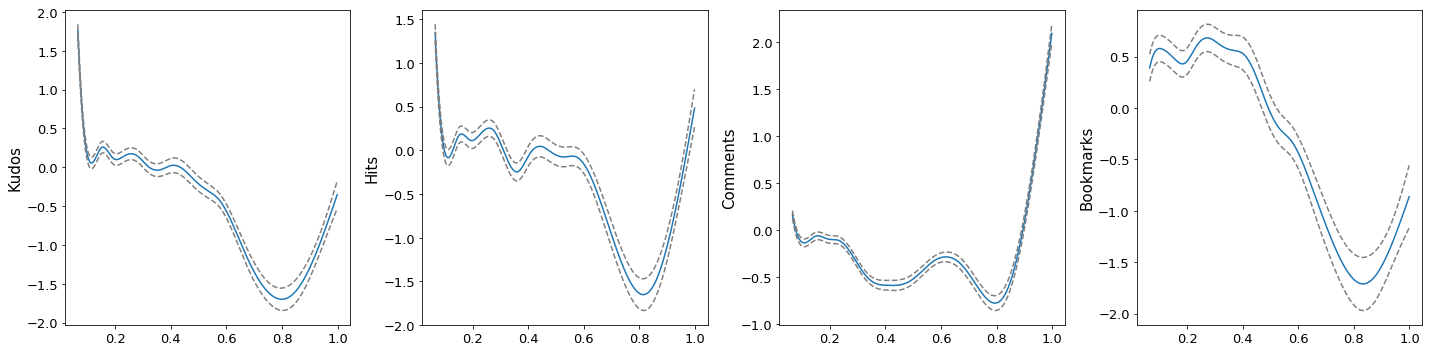

In [29]:
titles = ['ChapterIndex', 'Chapters','Term_novelty', 'Topic_novelty',
       'Category_F_F', 'Category_F_M', 'Category_Gen', 'Category_M_M',
       'Category_Multi', 'Category_Other', 'Category_None',
       'ArchiveWarnings_none', 'ArchiveWarnings_underage',
       'ArchiveWarnings_death', 'ArchiveWarnings_choose_no',
       'ArchiveWarnings_no_apply', 'ArchiveWarnings_blood',
       'ArchiveWarnings_violence', 'ArchiveWarnings_noncon',
       'Freq_author', 'Rating_E', 'Rating_G', 'Rating_M', 'Rating_N',
       'Rating_T', 'Freq_relationship', 'Fandom_harry_potter',
       'Fandom_dcu', 'Fandom_doctor_who', 'Fandom_star_wars',
       'Fandom_arthurian', 'Fandom_supernatural', 'Fandom_haikyuu',
       'Fandom_kuroko_no_basuke', 'Fandom_hamilton_miranda',
       'Fandom_dragon_age', 'Fandom_the_walking_dead', 'Fandom_buffy',
       'Fandom_les_miserables', 'Fandom_naruto', 'Fandom_tolkien',
       'Fandom_shakespare', 'Fandom_hetalia', 'Fandom_attack_on_titan',
       'Fandom_ms_paint_adventures', 'Fandom_homestuck', 'Fandom_marvel',
       'Fandom_sailor_moon', 'Fandom_one_direction', 'Fandom_sherlock',
       'History']

plt.figure(figsize = (20, 5))
plt.subplot(1,4,1)

X1 = generate_X_grid(gam_kudos)
pdep, confi = gam_kudos.partial_dependence(X1, feature=2, width=.95)
plt.plot(X1[:, 2], pdep)
plt.plot(X1[:, 2], confi[0][:, 0], c='grey', ls='--')
plt.plot(X1[:, 2], confi[0][:, 1], c='grey', ls='--')
plt.ylabel('Kudos', fontsize=15)
plt.tick_params(labelsize=13)


plt.subplot(1,4,2)

X2 = generate_X_grid(gam_hits)
pdep, confi = gam_hits.partial_dependence(X2, feature=2, width=.95)
plt.plot(X2[:, 2], pdep)
plt.plot(X2[:, 2], confi[0][:, 0], c='grey', ls='--')
plt.plot(X2[:, 2], confi[0][:, 1], c='grey', ls='--')
plt.ylabel('Hits', fontsize=15)
plt.tick_params(labelsize=13)

plt.subplot(1,4,3)

X3 = generate_X_grid(gam_comments)
pdep, confi = gam_comments.partial_dependence(X3, feature=2, width=.95)
plt.plot(X3[:, 2], pdep)
plt.plot(X3[:, 2], confi[0][:, 0], c='grey', ls='--')
plt.plot(X3[:, 2], confi[0][:, 1], c='grey', ls='--')
plt.ylabel('Comments', fontsize=15)
plt.tick_params(labelsize=13)

plt.subplot(1,4,4)

X4 = generate_X_grid(gam_bookmarks)
pdep, confi = gam_bookmarks.partial_dependence(X4, feature=2, width=.95)
plt.plot(X4[:, 2], pdep)
plt.plot(X4[:, 2], confi[0][:, 0], c='grey', ls='--')
plt.plot(X4[:, 2], confi[0][:, 1], c='grey', ls='--')
plt.ylabel('Bookmarks', fontsize=15)

plt.tick_params(labelsize=13)

plt.tight_layout()
# plt.savefig('gam_results_term_rm.pdf', type = 'pdf')

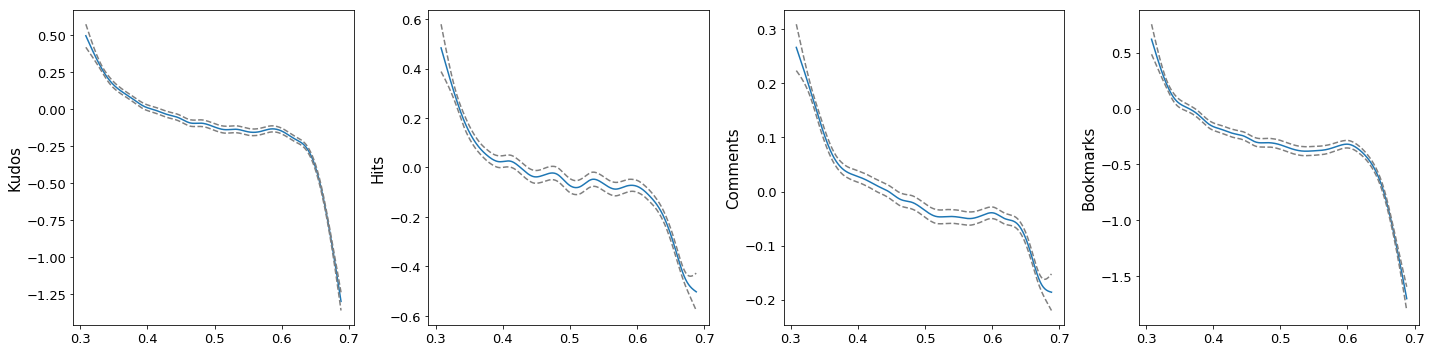

In [30]:
titles = ['ChapterIndex', 'Chapters','Term_novelty', 'Topic_novelty',
        'Category_F_M', 'Category_Gen', 'Category_M_M',
       'Category_Multi', 'Category_Other', 'Category_Unknown',
        'ArchiveWarnings_underage',
       'ArchiveWarnings_death', 'ArchiveWarnings_choose_no',
       'ArchiveWarnings_no_apply',
       'ArchiveWarnings_violence', 'ArchiveWarnings_noncon',
       'author_fic_cnt',  'Rating_G', 'Rating_M', 'Rating_N',
       'Rating_T', 'Freq_relationship',
       'Fandom_dcu', 'Fandom_doctor_who', 'Fandom_star_wars',
       'Fandom_arthurian', 'Fandom_supernatural', 'Fandom_haikyuu',
       'Fandom_kuroko_no_basuke', 'Fandom_hamilton_miranda',
       'Fandom_dragon_age', 'Fandom_the_walking_dead', 'Fandom_buffy',
       'Fandom_les_miserables', 'Fandom_naruto', 'Fandom_tolkien',
       'Fandom_shakespare', 'Fandom_hetalia', 'Fandom_attack_on_titan',
       'Fandom_ms_paint_adventures', 'Fandom_homestuck', 'Fandom_marvel',
       'Fandom_sailor_moon', 'Fandom_one_direction', 'Fandom_sherlock',
       'History']

plt.figure(figsize = (20, 5))
plt.subplot(1,4,1)

X1 = generate_X_grid(gam_kudos)

pdep, confi = gam_kudos.partial_dependence(X1, feature=3, width=.95)
plt.plot(X1[:,3], pdep)
plt.plot(X1[:,3], confi[0][:, 0], c='grey', ls='--')
plt.plot(X1[:,3], confi[0][:, 1], c='grey', ls='--')
plt.ylabel('Kudos', fontsize=15)
plt.tick_params(labelsize=13)

plt.subplot(1,4,2)

X2 = generate_X_grid(gam_hits)
pdep, confi = gam_hits.partial_dependence(X2, feature=3, width=.95)
plt.plot(X2[:, 3], pdep)
plt.plot(X2[:, 3], confi[0][:, 0], c='grey', ls='--')
plt.plot(X2[:, 3], confi[0][:, 1], c='grey', ls='--')
plt.ylabel('Hits', fontsize=15)
plt.tick_params(labelsize=13)

plt.subplot(1,4,3)

X3 = generate_X_grid(gam_comments)
pdep, confi = gam_comments.partial_dependence(X3, feature=3, width=.95)
plt.plot(X3[:, 3], pdep)
plt.plot(X3[:, 3], confi[0][:, 0], c='grey', ls='--')
plt.plot(X3[:, 3], confi[0][:, 1], c='grey', ls='--')
plt.ylabel('Comments', fontsize=15)
plt.tick_params(labelsize=13)

plt.subplot(1,4,4)

X4 = generate_X_grid(gam_bookmarks)
pdep, confi = gam_bookmarks.partial_dependence(X4, feature=3, width=.95)
plt.plot(X4[:, 3], pdep)
plt.plot(X4[:, 3], confi[0][:, 0], c='grey', ls='--')
plt.plot(X4[:, 3], confi[0][:, 1], c='grey', ls='--')
plt.ylabel('Bookmarks', fontsize=15)
plt.tick_params(labelsize=13)

    

plt.tight_layout()
# plt.savefig('gam_results_topic_rm.pdf', type = 'pdf')